In [ ]:
# Generic imports
#%%
import os
import random
import shutil
import progress.bar
from   datetime import datetime
from scipy.stats import qmc
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

import shapes
import meshes
import importlib

importlib.reload(shapes)
importlib.reload(meshes)

from shapes import *
from meshes import *

### ************************************************
### Generate full dataset
# Parameters
def generate_samples(numero_samples,n_base, latin_gen_bool):
    n_sampling_pts = 20
    mesh_domain    = False
    plot_pts       = True
    show_quadrants = True
    n_shapes       = numero_samples
    time           = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
    dataset_dir    = 'dataset_'+time+'/'
    mesh_dir       = dataset_dir+'meshes/'
    img_dir        = dataset_dir+'images/'
    det_img_dir    = dataset_dir+'det_images/'
    bit_img_dir    = dataset_dir+'bit_images/'
    save_det_plot = False

    filename       = 'shape'
    magnify        = 1.0
    max_radius = (2)**0.5
    xmin           =-2.0
    xmax           = 2.0
    ymin           =-2.0
    ymax           = 2.0
    n_tri_max      = 5000
    n_pts = n_base

    ### generate latin hypercube points in the defined space
    equ_dim_lim = 1.5

    if latin_gen_bool != False:
        latin_gen = qmc.LatinHypercube(d=n_pts*2)
        latin_gen = latin_gen.random(n=n_shapes)
        latin_gen = equ_dim_lim * latin_gen

        latin_gend2 = qmc.LatinHypercube(d=n_pts*2)
        latin_gend2 = latin_gend2.random(n=n_shapes)
        latin_gend2 = latin_gend2 * 0.9
        radius_tot = latin_gend2.reshape(-1,n_shapes,n_pts)
        edgy_tot   = latin_gend2.reshape(-1,n_shapes,n_pts)
    else:
        latin_gen = False


    # Create directories if necessary
    if not os.path.exists(mesh_dir):
        os.makedirs(mesh_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    if not os.path.exists(det_img_dir):
        os.makedirs(det_img_dir)
    if not os.path.exists(bit_img_dir):
        os.makedirs(bit_img_dir)

    # Generate dataset
    bar = progress.bar.Bar('Generating shapes', max=n_shapes)
    df = pd.DataFrame(columns=['curve_points', 'area', 'perimeter','bitmap'])

    for i in range(0,n_shapes):
        generated = False
        while (not generated):
            if not latin_gen_bool:
                #n_pts  = random.randint(3, 7)
                radius = np.random.uniform(0.3, .9, size=n_pts)
                edgy   = np.random.uniform(0.1, .5, size=n_pts)
            else:
                radius = radius_tot[0,i,:]
                edgy   = radius_tot[1,i,:]

            shape  = Shape(filename+'_'+str(i),
                        None,
                        n_pts,
                        n_sampling_pts,
                        radius,
                        edgy,
                        save_det_plot = save_det_plot)
            
            shape.generate(magnify=1.0,
                        xmin=xmin,
                        xmax=xmax,
                        ymin=ymin,
                        ymax=ymax,
                        latin_gen = latin_gen)
            
            if save_det_plot:
                img  = filename+'_'+str(i)+"det_plot"+'.png'
                shutil.move(img,  det_img_dir)
            
            shape.generate_bitmap(bit_im=False)

            img  = filename+'_'+str(i)+"bit"+'.png'
            shutil.move(img,  bit_img_dir)


            new_rows = [{'curve_points': shape.curve_pts, 'area': shape.area, 'perimeter': shape.curve_length, "bitmap": shape.bitmap}]
            df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
            generated = True
            #meshed, n_tri = shape.mesh()
            """
            if (True):
                shape.generate_image(plot_pts=plot_pts,
                                    max_radius = max_radius,
                                    xmin=xmin,
                                    xmax=xmax,
                                    ymin=ymin,
                                    ymax=ymax,
                                    show_quadrants=True)
                img  = filename+'_'+str(i)+'.png'
                mesh = filename+'_'+str(i)+'.mesh'
                shutil.move(img,  img_dir)
                #shutil.move(mesh, mesh_dir)
                generated = True
            """
        bar.next()
    bit = df["bitmap"]
    curve = df["area"]
    # End bar
    bar.finish()
    return bit,df


In [21]:
def generate_data_indicators(latin_gen = False, number_of_samples = 100, seeds = 4):
    list_mse_mean = np.array([])
    list_mse_var = np.array([])
    seeds = seeds
    bit, df1 = generate_samples(number_of_samples,seeds, latin_gen)
    stack1 = np.stack(bit.values)
    mean1_img = np.mean(stack1, axis=0)
    mse1 = np.mean((stack1 - mean1_img) ** 2, axis=(1, 2))
    mean1 = np.mean(mse1)
    var1 = np.var(mse1)
    list_mse_mean = np.append(list_mse_mean, mean1)
    list_mse_var = np.append(list_mse_var, var1)

    points = df1["curve_points"]
    df1["angles"] = None
    df1["angles"] = df1["angles"].astype(object)
    df1["spectra"] = None
    df1["spectra"] = df1["spectra"].astype(object)
    limit = 20
    for index,row in df1.iterrows():
        points = row["curve_points"]
        angles = np.arctan2(points[:, 1], points[:, 0])
        df1.at[index, "angles"] = angles
        og_data = np.linalg.norm(points, axis = 1)

        fs1 = angles.shape[0]/(2*np.pi)
        samples1 = og_data
        fft1 = fft(og_data)
        freqs1 = fftfreq(len(samples1), 1/fs1)
        df1.at[index,"spectra"] = fft1[:limit]/points.shape[0]

    spectra = df1["spectra"]
    spectra = np.stack(spectra.values)
    var_energy = spectra.var(axis = 0)
    mean_energy = abs(spectra).mean(axis = 0)

    var_angle = np.angle(spectra).var(axis = 0)
    mean_angle = np.angle(spectra).mean(axis = 0)

    return var_energy, mean_energy, var_angle, mean_angle
    

In [ ]:
points = df1["curve_points"]
df1["angles"] = None
df1["angles"] = df1["angles"].astype(object)
df1["spectra"] = None
df1["spectra"] = df1["spectra"].astype(object)
limit = 20
for index,row in df1.iterrows():
    points = row["curve_points"]
    angles = np.arctan2(points[:, 1], points[:, 0])
    df1.at[index, "angles"] = angles
    og_data = np.linalg.norm(points, axis = 1)

    fs1 = angles.shape[0]/(2*np.pi)
    samples1 = og_data
    fft1 = fft(og_data)
    freqs1 = fftfreq(len(samples1), 1/fs1)
    df1.at[index,"spectra"] = fft1[:limit]/points.shape[0]
spectra = df1["spectra"]
spectra = np.stack(spectra.values)
var = spectra.var(axis = 0)
mean= abs(spectra).mean(axis = 0)

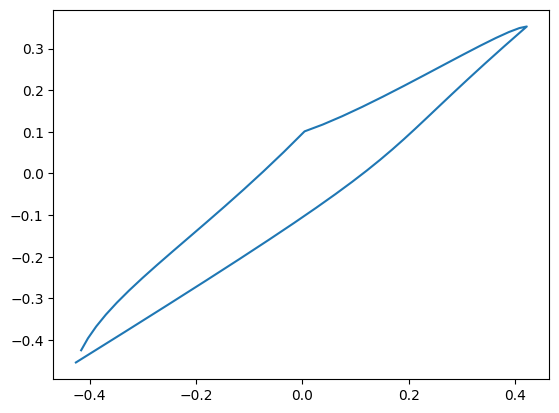

In [6]:
index = 2
points = df1["curve_points"][index][:,:2]
angles = np.arctan2(points[:, 1], points[:, 0])
og_data = np.linalg.norm(points, axis = 1)
plt.plot(points[:,0], points[:,1])

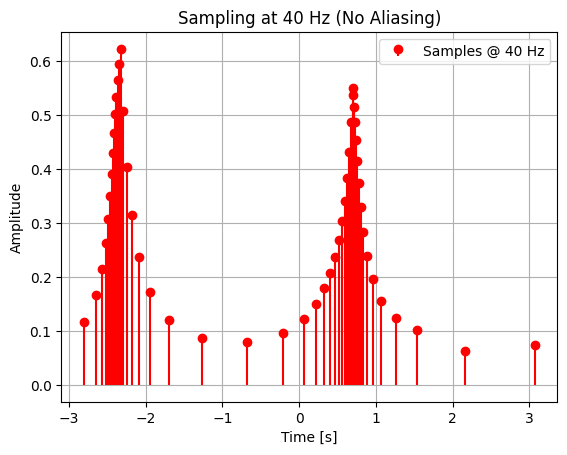

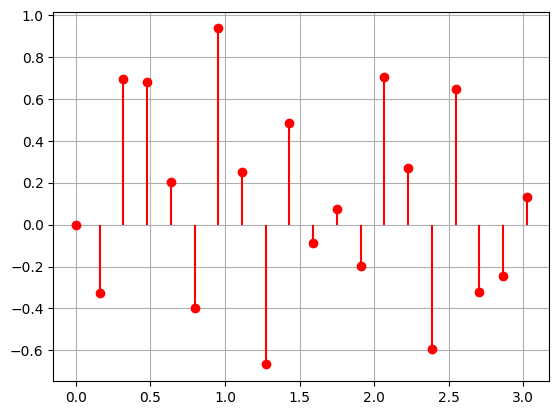

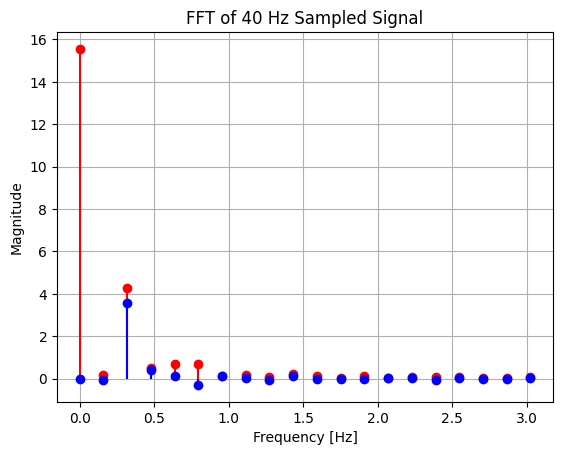

In [7]:
# Case 1: Sampling at 40 Hz
limit = 20
fs1 = angles.shape[0]/(2*np.pi)
t1 = angles
samples1 = og_data
fft1 = fft(og_data)
freqs1 = fftfreq(len(samples1), 1/fs1)

# Plotting
fig1, ax = plt.subplots()
#ax.plot(t_high_res, signal, label="Original Signal (10 Hz)")
ax.stem(t1, samples1, linefmt='r-', markerfmt='ro', basefmt=" ", label="Samples @ 40 Hz")
ax.set_title("Sampling at 40 Hz (No Aliasing)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.legend()
ax.grid()

fig2, ax = plt.subplots()
ftheta = np.angle(fft1)
ax.stem(freqs1[:limit], ftheta[:limit].real, linefmt='r-', markerfmt='ro', basefmt=" ")
ax.grid()


fig3, ax = plt.subplots()
#ax.stem(freqs1[:limit], abs(fft1[:limit]), linefmt='r-', markerfmt='ro', basefmt=" ")
ax.stem(freqs1[:limit], fft1[:limit].real, linefmt='r-', markerfmt='ro', basefmt=" ")
ax.stem(freqs1[:limit], fft1[:limit].imag, linefmt='b-', markerfmt='bo', basefmt=" ")

ax.set_title("FFT of 40 Hz Sampled Signal")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude")
ax.grid()


In [ ]:
spectra = df1["spectra"]
spectra = np.stack(spectra.values)
var = spectra.var(axis = 0)
mean= abs(spectra).mean(axis = 0)

In [9]:
spectra.shape

(100, 20)

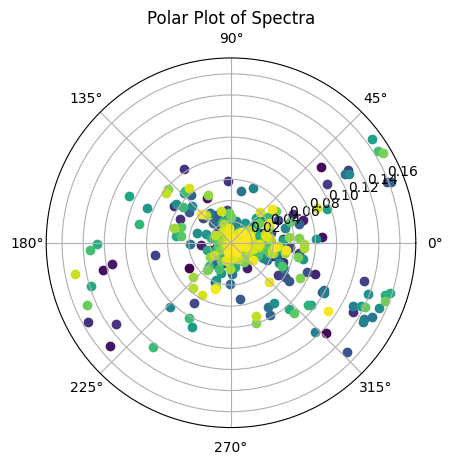

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(111, polar=True)
colors = plt.cm.viridis(np.linspace(0, 1, spectra.shape[0]))

for i in range(spectra.shape[0]):
    theta = np.angle(spectra[i, 1:])
    r = np.abs(spectra[i, 1:])
    ax.scatter(theta, r, color=colors[i], label=f"Spectrum {i}")

plt.title("Polar Plot of Spectra")
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.show()



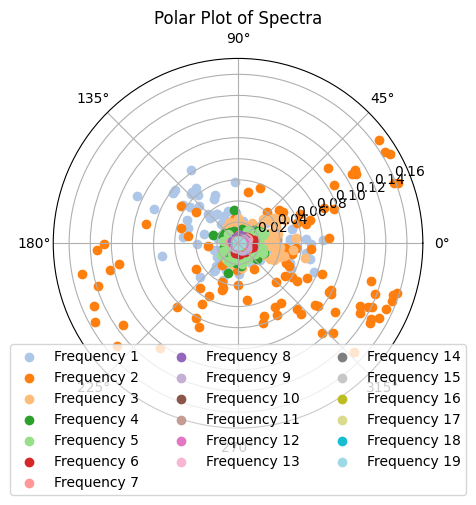

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(111, polar=True)
colors = plt.cm.tab20(np.linspace(0, 1, spectra.shape[1]))

for i in range(1,spectra.shape[1]):
    theta = np.angle(spectra[:, i])
    r = np.abs(spectra[:,i])
    ax.scatter(theta, r, color=colors[i], label=f"Frequency {i}")

plt.title("Polar Plot of Spectra")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.show()

In [13]:
var = spectra.var(axis = 0)
mean= abs(spectra).mean(axis = 0)

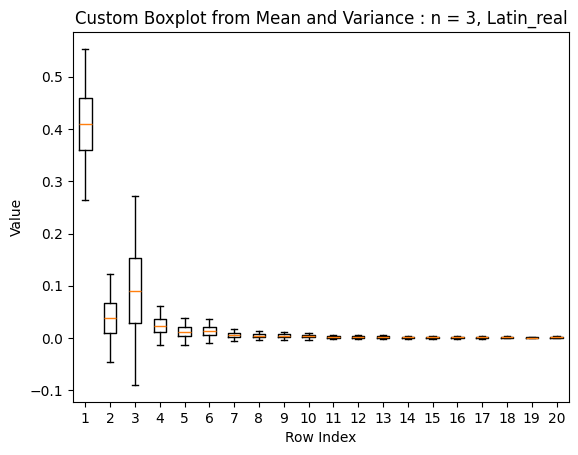

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `mean` and `var` are your [20, n] arrays
# Example placeholders:
# mean = np.random.rand(20, n)
# var = np.random.rand(20, n)

std = np.sqrt(var)
q1 = mean - 0.674 * std  # Approx 25th percentile
q3 = mean + 0.674 * std  # Approx 75th percentile
med = mean               # Using mean as median approximation
whis_lo = mean - 1.96 * std  # Approx lower whisker (2.5th percentile)
whis_hi = mean + 1.96 * std  # Approx upper whisker (97.5th percentile)

# Now create custom boxplot data for each row
box_data = []
for i in range(mean.shape[0]):
    box_data.append({
        'med': np.mean(med[i]),
        'q1': np.mean(q1[i]),
        'q3': np.mean(q3[i]),
        'whislo': np.min(whis_lo[i]),
        'whishi': np.max(whis_hi[i]),
        'fliers': []  # You can simulate outliers if needed
    })

# Create boxplot
fig, ax = plt.subplots()
ax.bxp(box_data, showfliers=False)
ax.set_title(f"Custom Boxplot from Mean and Variance : n = {seeds}, Latin_real")
ax.set_xlabel("Row Index")
ax.set_ylabel("Value")
plt.show()


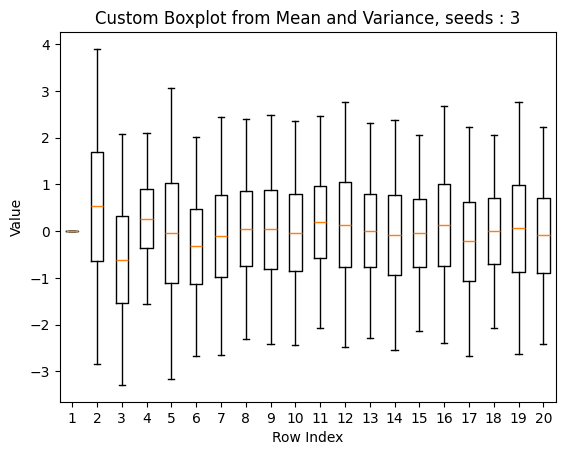

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `mean` and `var` are your [20, n] arrays
# Example placeholders:
# mean = np.random.rand(20, n)
# var = np.random.rand(20, n)
var = np.angle(spectra).var(axis = 0)
mean= np.angle(spectra).mean(axis = 0)

std = np.sqrt(var)
q1 = mean - 0.674 * std  # Approx 25th percentile
q3 = mean + 0.674 * std  # Approx 75th percentile
med = mean               # Using mean as median approximation
whis_lo = mean - 1.96 * std  # Approx lower whisker (2.5th percentile)
whis_hi = mean + 1.96 * std  # Approx upper whisker (97.5th percentile)

# Now create custom boxplot data for each row
box_data = []
for i in range(mean.shape[0]):

    box_data.append({
        'med': np.mean(med[i]),
        'q1': np.mean(q1[i]),
        'q3': np.mean(q3[i]),
        'whislo': np.min(whis_lo[i]),
        'whishi': np.max(whis_hi[i]),
        'fliers': []  # You can simulate outliers if needed
    })

# Create boxplot
fig, ax = plt.subplots()
ax.bxp(box_data, showfliers=False)
ax.set_title(f"Custom Boxplot from Mean and Variance, seeds : {seeds}")
ax.set_xlabel("Row Index")
ax.set_ylabel("Value")
plt.show()


In [18]:
spectra.shape

(100, 20)

In [19]:
df1

,curve_points,area,perimeter,bitmap,angles,spectra
0,"[[-0.13591432595608122, -0.3372014113270768, 0...",-1.636607,2.648503,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1.953942759502837, -1.8842268822229347, -1.7...","[(0.3746520481875983-0j), (-0.0183017899194242..."
1,"[[0.5743841758626108, -0.4026777202176949, 0.0...",-0.661420,2.696048,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.6114369610734941, -0.5858687769787313, -0....","[(0.3719314869699044-0j), (0.01038634659408328..."
2,"[[-0.4258976814097925, -0.4540078077143056, 0....",-0.424433,2.338421,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-2.3242585953909582, -2.2910413178760063, -2....","[(0.3109983663810627-0j), (0.00368520158866420..."
3,"[[-0.051030761487917964, -0.1323923578172168, ...",-1.102965,2.734155,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1.9386978553674066, -1.6380293856749442, -1....","[(0.3871888265697932-0j), (-0.0038345299538572..."
4,"[[0.6033118647089152, -0.6644875000186536, 0.0...",-2.605737,3.344913,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.8336141689935523, -0.7629096969106054, -0....","[(0.49727394669433417-0j), (0.0554260573011208..."
...,...,...,...,...,...,...
95,"[[-0.04836689393425153, -0.5515642986634723, 0...",-2.463249,2.990326,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1.6582629898699655, -1.554525288592391, -1.4...","[(0.45590145184173636-0j), (0.0106768175027199..."
96,"[[-0.41310579761287713, -0.401901483103966, 0....",-1.554929,2.625719,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-2.3699411265786483, -2.3285912798256065, -2....","[(0.37521622779825875-0j), (-0.001443331257056..."
97,"[[-0.5112819726823776, -0.6231588270149349, 0....",-2.656463,3.459478,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-2.257893841971207, -2.1774890329856142, -2.0...","[(0.4736513679685397-0j), (0.02108950272790457..."
98,"[[0.4393734844178455, -0.703696508316861, 0.0]...",-1.633138,3.131828,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1.012643531994215, -0.9700560056544267, -0.9...","[(0.44774020084478605-0j), (0.0415432049521425..."


In [ ]:
for elements in range(np.[3,7]):
    print(elements)

TypeError: 'list' object cannot be interpreted as an integer

In [3]:
import numpy as np
np.arange([3,7])

TypeError: unsupported operand type(s) for -: 'list' and 'int'